# Optimal transport non-linearities and boundary conditions, in 1D

The PDE formulation of the optimal transport problem reads as follows:
$$
    f(x)-g(\nabla u(x))\det(\nabla^2 u(x)) = 0,
$$
subject to the constraint
$$
    u \quad \text{convex},
$$
and the boundary condition
$$
    \nabla u(X) = Y,
$$
where $X$ is the source domain, and $Y$ is the target domain. The parameters of the PDE are the densities $f$ and $g$, which are non-negative and subject to the compatibility condition
$$
    \int_X f(x) dx = \int_Y g(y) dy.
$$

This mathematical problem comes with a number of challenges, of both theoretical and numerical nature, including the:
1. Full non-linearity of the second order operator.
2. Constraint of convexity
3. Unspecified non-linearity of the first order operator.
4. Lack of a comparison principle.

Challenges 1. and 2. are related with the Monge-Ampere operator $\det(\nabla^2 u)$. They are discussed  the notebook 
[C.I Monge-Ampere equations](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/MongeAmpere.ipynb)

This notebook is devoted to challenges 3. and 4., in a simplified one dimensional setting.
In practice, 3. is mostly an implementation problem. Substantial theoretical work has been required to address 4. however. It is based on the observation that the second boundary condition could be weakened into 
$$
    \nabla u(X) \subset Y,
$$
and that equality must hold for the solution due to the compatibility condition relating the problem parameter densities.

**Note on one dimensional optimal transport.**
It is well known that one dimensional optimal transport (with a convex cost function) is nothing else than a sorting problem. As such it can be solved extremely efficiently, at a quasi-linear cost, and is considered a solved algorithmic problem.
The interest of numerical techniques presented in this notebook lies is their possible extension to higher dimensions.

**References**

* Benamou, J.-D., & Duval, V. (2017). Minimal convex extensions and finite difference discretisation of the quadratic Monge--Kantorovich problem. European Journal of Applied Mathematics, 1–38.

## The one-dimensional problem

In dimension one, the Monge-Ampere operator reduces to the usual laplacian operator, and the related difficulties 1. and 2. disappear. We are left with the equation
$$
    f(x) - g(u'(x)) u''(x) = 0,
$$
subject to the boundary conditions
$$
    u'(x_*) =  y_*, \quad u'(x^*) = y^*,
$$
where $X=[x_*,x^*]$ and $Y = [y_*,y^*]$ are the source and target intervals. Again the problem parameters are subject to the compatibility conditions
$$
    \int_{x_*}^{x^*} f(x) dx = \int_{y_*}^{y^*} g(y) dy,
$$
and this allows to weaken the boundary conditions into 
$$
    u'(x_*) \geq  y_*, \quad u'(x^*) \leq y^*.
$$

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import Selling
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import FiniteDifferences as fd
from NumericalSchemes import SparseAutomaticDifferentiation as spad

In [2]:
import numpy as np
import scipy.linalg; import scipy.sparse; import scipy.sparse.linalg 
from matplotlib import pyplot as plt
import time

Some utility functions

In [3]:
def LInfNorm(a):
    return np.max(np.abs(np.array(a)))

In [4]:
def solve_residue(res):
    return - scipy.sparse.linalg.spsolve(
        scipy.sparse.coo_matrix(res.triplets()).tocsr(),
        np.array(res).flatten()).reshape(res.shape)

def solve_Newton(Scheme,params,guess,print_period=1,niter=8,relax=0.):
    u = guess+spad.identity(guess.shape)
    for i in range(niter):
        residue = Scheme(u,*params)
        if (i-1)%print_period ==0 or i==niter-1:
            print("Iteration :",i,", Residue norm :", LInfNorm(residue))
        u += solve_residue(residue+relax)
    return np.array(u)

In [5]:
import importlib
fd = importlib.reload(fd)
spad = importlib.reload(spad)
lp = importlib.reload(lp)
Selling = importlib.reload(Selling)

## 1. Second boundary conditions

We further simplify the problem and assume $g \equiv 1$, to study the weakened *second boundary conditions* that we rewrite as 
$$
    y_* - u'(x_*) \leq 0, \quad u'(x^*) - y^*\leq 0,
$$
at the endponts of the interval $[x_*,x^*]$ of definition of the problem solution $u$.
Recall that the PDE solved is 
$$
    f(x) - u''(x) = 0,
$$
and that we have 
$$
    \int_{x_*}^{x^*} f(x) dx = y^*-y_*.
$$

**Explicit solution.**
The above problem admits a one dimensional, family of explicit solutions. Namely
$$
u(x) = \alpha + r x + v(x),
$$
where $v$ is a second primitive of $u$, and the constant $r$ is adequately chosen to match the boundary conditions.
The other constant, named $\alpha$, is *arbitrary*.

### Montone discretization

We may define a monotone (degenerate elliptic) discretization of the boundary conditions, using upwind finite differences as follows
$$
    \max\{0,y_* - \frac{u(x_*+h)-u(x_*)} h\} = 0, \quad \max\{0,\frac{u(x^*)-u(x^*-h)} h - y^*\}= 0.
$$
We also use the standard discretization of the laplacian operator in the interior.

The resulting discretization obeys the assumptions of a degenerate elliptic (monotone) scheme, since it takes the form
$$
    F u(x) := F(x,u(x),(u(x)-u(x'))_{x' \in X} ),
$$
where $F$ is a non-decreasing function of its second and third arguments.

### Non-uniqueness and lack of a comparision principle

The continuous problems admits, as mentioned above, a one dimensional family of solutions. The discrete problem, on the other hand, admits either no solution, or a large and typically multi-dimensional family of solutions.

These indeterminacies reflect a failure of the comparison principle, due to the impossibility to perturb a given solution into a strict sub-solution.

In [6]:
def Scheme(u,f,bc,h):
    residue = f-fd.Diff2(u,(1,),h)
    residue[0]  = spad.maximum(0.,bc[0] - (u[1]-u[0])/h)
    residue[-1] = spad.maximum(0.,(u[-1]-u[-2])/h - bc[1])
    return residue

In [7]:
X = np.linspace(-1,1,101,endpoint=True)
gridScale = X[1]-X[0]
f = 1.+0.9*np.sin(2.*np.pi*X)
bc = np.array((-1,1))

guess = np.zeros(X.shape)

The discretized problem is linear. However, the jacobian matrix $J$ is rank deficient and non-invertible.
Fortunately, thanks to the scheme monotony, the matrix 
$$
    J+\epsilon {\rm Id} 
$$
is invertible for every $\epsilon>0$.
We use an iterative method, featuring such a relaxation, so solve the problem.

In order to illustrate the dichotomy between *no solution* and *infinitely may solutions, we perturb a bit the boundary conditions.

**Note on convergence (No solution).**
The discretized problem addressed here has *no solution*. As a result, the Newton solver residues do not tend to zero (or numerical precision). This is expected behavior.

In [8]:
bc2 = np.array((-1,1-2*gridScale))
params = (f,bc2,gridScale)
relax = spad.identity(X.shape)*gridScale
solution = solve_Newton(Scheme,params,guess,relax=relax)

Iteration : 0 , Residue norm : 1.8982240555854444
Iteration : 1 , Residue norm : 0.12636527953248167
Iteration : 2 , Residue norm : 3.004300912710269
Iteration : 3 , Residue norm : 0.11427135703730329
Iteration : 4 , Residue norm : 0.007087103604890288
Iteration : 5 , Residue norm : 0.005254916516888031
Iteration : 6 , Residue norm : 0.006685894954716609
Iteration : 7 , Residue norm : 0.006683393190220599


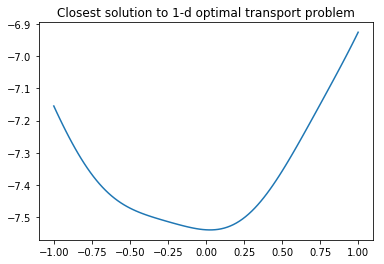

In [9]:
plt.title("Closest solution to 1-d optimal transport problem")
plt.plot(X,solution);

We next perturb a bit the boundary conditions, ensuring, this time, that the discretized problem has *an infinity of solutions*.

**Note on convergence (degenerate solutions).**
The discretized problem addressed here has a two dimensional non-linear family of solutions. It is also non-differentiable. As a result, the Newton solve takes more steps to reach numerical precision than what could be expected for problems this size.

In [10]:
bc3 = np.array((-1,1+2*gridScale))
params = (f,bc3,gridScale)
relax = spad.identity(X.shape) * gridScale
solution = solve_Newton(Scheme,params,guess,relax=relax,niter=15)

Iteration : 0 , Residue norm : 1.8982240555854444
Iteration : 1 , Residue norm : 0.12636527953248167
Iteration : 2 , Residue norm : 2.924300912710269
Iteration : 3 , Residue norm : 0.11126983809208268
Iteration : 4 , Residue norm : 0.006901327729131879
Iteration : 5 , Residue norm : 0.00044177872508655014
Iteration : 6 , Residue norm : 2.8353774990108604e-05
Iteration : 7 , Residue norm : 1.8201992091348984e-06
Iteration : 8 , Residue norm : 1.1685201251054878e-07
Iteration : 9 , Residue norm : 7.501617105276637e-09
Iteration : 10 , Residue norm : 4.815881027298019e-10
Iteration : 11 , Residue norm : 3.297728756734841e-11
Iteration : 12 , Residue norm : 1.2192469256433469e-11
Iteration : 13 , Residue norm : 8.259171124791465e-12
Iteration : 14 , Residue norm : 1.0933476346508542e-11


## 2. Non-linearity in the gradient 

We solve the PDE 
$$
f(x)/g(u'(x)) - u''(x)=0
$$

In [11]:
#def LinearInterpolate(data,position,bounds,mode='clip',axis=0):
#    endpoint=not (mode==wrap)
#    s=

SyntaxError: invalid syntax (<ipython-input-11-5a36bff524c1>, line 3)

In [ ]:
def MultilinearInterpolate(data,position,bounds,mode='clip'):
    endpoint = not (mode=='wrap')
        
    shape = data.shape[:len(position)]
    index_continuous = (shape-int(endpoint))*(position - bounds[0])/(bounds[0]-bounds[1])
    index0 = np.floor(index_continuous).astype(int)
    index1 = np.ceil(index_continuous).astype(int)
    index_rem = index_continuous-index0
    
    for x0,x1,s in zip(index0,index1,shape):
        if mode=='wrap':
            index0=index0%s
            index1=index1%s
        elif mode=='clip':
            index0 = np.min(np.max(index0,0),s-1)
            index1 = np.min(np.max(index1,0),s-1)
    
    assert 0


        
    
    

In [ ]:
from scipy.interpolate import RegularGridInterpolator

In [ ]:
interp = RegularGridInterpolator((X,),np.sin(X))

In [ ]:
interp([[0.5]])

In [ ]:
np.sin(0.5)

In [ ]:
interp(spad.identity(X.shape)+X)